In [1]:
import ee

In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
import ee, datetime
import pandas as pd
import geopandas as gpd
import matplotlib.dates as mdates
from IPython.display import Image
from matplotlib import dates
from shapely.geometry import shape
import skimage

In [85]:
import ee
import folium

# Google Earth Engine 초기화
ee.Initialize()

# 주어진 GeoJSON 영역
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              128.88464250312234,
              36.779162550309564
            ],
            [
              128.8122196894634,
              36.779472130130486
            ],
            [
              128.7343977299123,
              36.70789960842015
            ],
            [
              128.6753917828524,
              36.73429495982205
            ],
            [
              128.59929945476784,
              36.716360900733434
            ],
            [
              128.59106473930376,
              36.6641947508807
            ],
            [
              128.49979850744,
              36.64035452741791
            ],
            [
              128.42278397329505,
              36.622848950577875
            ],
            [
              128.38559721205866,
              36.63846345718984
            ],
            [
              128.3627331877708,
              36.59847054187699
            ],
            [
              128.35232385052012,
              36.551550011788876
            ],
            [
              128.42547814811456,
              36.561355060849124
            ],
            [
              128.46474009776216,
              36.570979688296475
            ],
            [
              128.480823209986,
              36.55328104357032
            ],
            [
              128.5507690587208,
              36.5234197336011
            ],
            [
              128.5546926787469,
              36.50296001139178
            ],
            [
              128.59031273246364,
              36.42896672561186
            ],
            [
              128.60673318347813,
              36.414583490144906
            ],
            [
              128.67476904726828,
              36.42350919135251
            ],
            [
              128.69549654847458,
              36.44031634985994
            ],
            [
              128.7052484072999,
              36.46158746610867
            ],
            [
              128.77104862262632,
              36.48535353887209
            ],
            [
              128.8572514837589,
              36.43327045571873
            ],
            [
              128.8930542458529,
              36.28244192966284
            ],
            [
              128.996425328015,
              36.38740236111059
            ],
            [
              129.02642330971014,
              36.42247364959344
            ],
            [
              129.01210946287853,
              36.48119021228561
            ],
            [
              128.9886720806249,
              36.50330502319724
            ],
            [
              128.95458092523165,
              36.526744141566965
            ],
            [
              128.97518494891182,
              36.53631953365323
            ],
            [
              128.97431151727568,
              36.56042381641056
            ],
            [
              128.9947716092865,
              36.59860396734332
            ],
            [
              128.97669714711964,
              36.62140321499207
            ],
            [
              128.99340667561478,
              36.69838886719158
            ],
            [
              128.99387548670165,
              36.70327527135463
            ],
            [
              128.99106262017204,
              36.715302019674
            ],
            [
              128.99856359758508,
              36.735592888734814
            ],
            [
              128.9929378645258,
              36.74160396845501
            ],
            [
              128.99481310887955,
              36.74986843443074
            ],
            [
              128.98356164275907,
              36.75362471564058
            ],
            [
              128.9488696222241,
              36.76038555836978
            ],
            [
              128.93855577827958,
              36.776158540620045
            ],
            [
              128.91980333474828,
              36.772778888998076
            ],
            [
              128.90667662427416,
              36.77991353433681
            ],
            [
              128.89354991380208,
              36.77766056018055
            ],
            [
              128.88464250312234,
              36.779162550309564
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# 기간 설정 및 Sentinel-1 데이터 가져오기
start_date = '2017-01-01'
end_date = '2023-03-31'

# AOI 설정
aoi = ee.Geometry.Polygon(geojson['features'][0]['geometry']['coordinates'])

# Create an ImageCollection for a specific date range, area, and parameters.
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('instrumentMode', 'IW'))
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')))

def add_rvi(image):
    # RVI 계산
    rvi = image.expression(
        '4 * float(VV) / (VV + VH) ** 2',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('RVI')

    # RVI 밴드 추가
    return image.addBands(rvi)

# NDVI 및 변화 추가
with_rvi_collection = collection.map(add_rvi)

In [96]:
import pandas as pd
import pandas as pd
from tqdm import tqdm
# 이미지 컬렉션에서 이미지들을 리스트로 변환
image_list = with_rvi_collection.toList(with_rvi_collection.size())

# 데이터프레임에 저장할 데이터를 담을 리스트
data = []

# AOI 내의 모든 이미지에 대해 반복하면서 평균값을 계산합니다.
for i in tqdm(range(image_list.size().getInfo())):
    # 이미지를 가져옵니다.
    image = ee.Image(image_list.get(i))
    # 이미지 촬영 날짜를 가져옵니다.
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    # NDVI 밴드의 AOI 영역에 대한 평균값을 계산합니다.
    mean_rvi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10  # 여기서 scale을 원하는 해상도로 설정하세요
    ).get('RVI').getInfo()  # 'NDVI' 대신 사용하고 있는 밴드의 이름을 사용하세요.

    # 날짜와 평균 NDVI 값을 데이터 리스트에 추가합니다.
    data.append({
        'ds': date,
        'y': mean_rvi
    })

# 데이터를 Pandas 데이터프레임으로 변환
df = pd.DataFrame(data)

# 결과 확인
print(df)

ee.ComputedObject({
  "functionInvocationValue": {
    "functionName": "List.get",
    "arguments": {
      "index": {
        "constantValue": 0
      },
      "list": {
        "functionInvocationValue": {
          "functionName": "Collection.toList",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.map",
                "arguments": {
                  "baseAlgorithm": {
                    "functionDefinitionValue": {
                      "argumentNames": [
                        "_MAPPING_VAR_0_0"
                      ],
                      "body": {
                        "functionInvocationValue": {
                          "functionName": "Image.addBands",
                          "arguments": {
                            "dstImg": {
                              "argumentReference": "_MAPPING_VAR_0_0"
                            },
                            "srcImg": {
      

EEException: Collection.toList: Error in map(ID=S1A_IW_GRDH_1SSV_20170114T092249_20170114T092318_014826_01828E_605D):
Image.select: Pattern 'VH' did not match any bands.

In [57]:
from prophet import Prophet
# Prophet 모델을 초기화하고 학습시킵니다.
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(df)

# 미래 날짜 프레임을 만들고 예측을 진행합니다.
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future) 

# 예측 결과를 가져옵니다.
forecasted_value = forecast.iloc[-1]['yhat']  # 예측된 값을 가져옴
print(f"Forecasted mean NDVI for the next period: {forecasted_value}")

# 예측 결과를 데이터프레임에 추가합니다.
forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)

# 결과 확인
print(forecast_df.tail())  # 마지막 5개의 결과를 출력합니다.

17:07:29 - cmdstanpy - INFO - Chain [1] start processing
17:07:29 - cmdstanpy - INFO - Chain [1] done processing


Forecasted mean NDVI for the next period: -0.04280863728661938
                      ds         y
219           2019-09-05 -0.050588
220           2020-08-18 -0.051188
221           2020-08-25 -0.051150
222           2020-08-30 -0.053059
223  2024-03-24 00:00:00 -0.042809


C:\Users\gunwo\AppData\Local\Temp\ipykernel_10420\2111206558.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)


In [79]:
import pandas as pd
from prophet import Prophet
import plotly.offline as py



In [80]:
fig = plot_plotly(m,forecast)

In [82]:
fig.show()

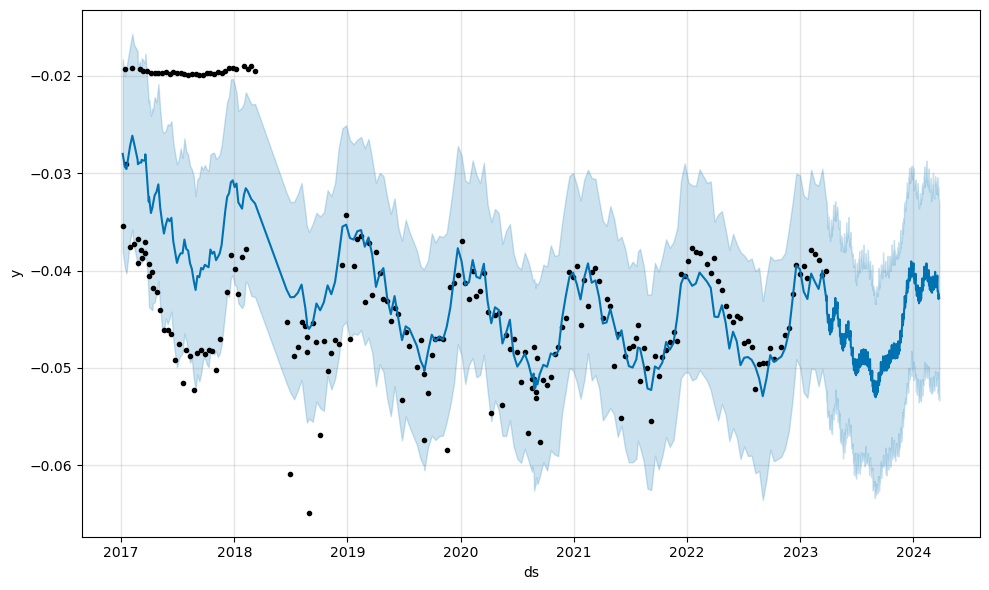

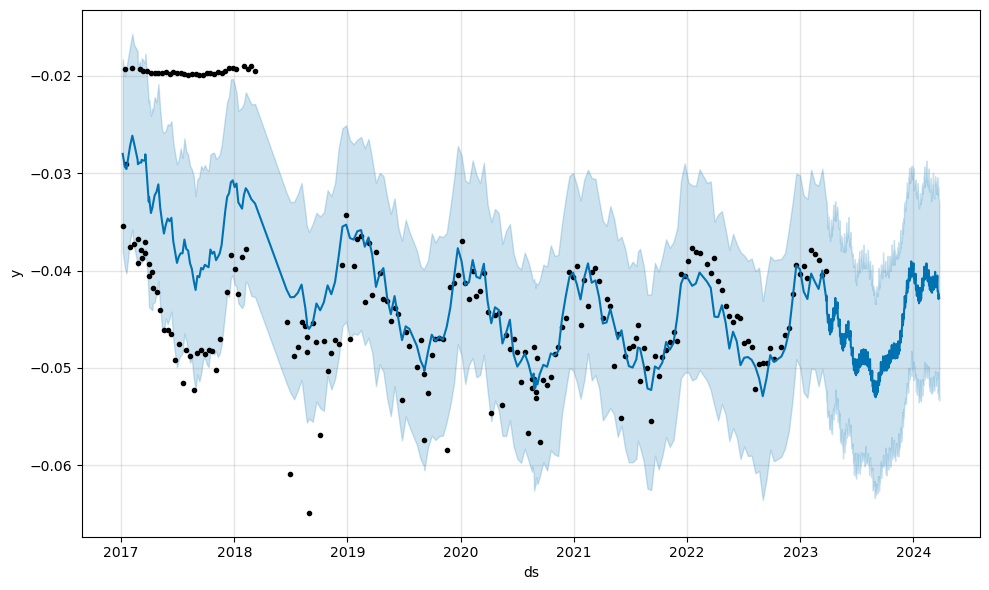

In [78]:
m.plot(forecast)

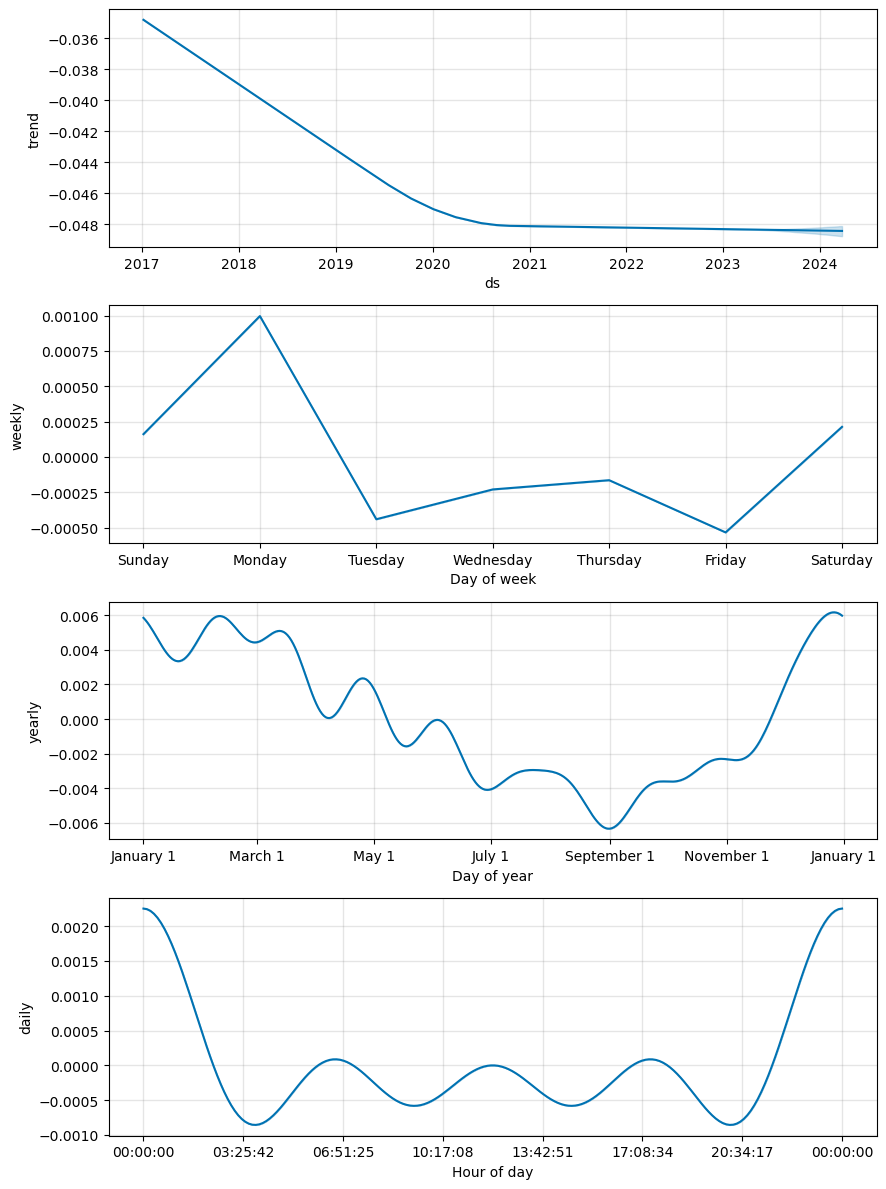

In [59]:
fig2 = m.plot_components(forecast)